In [1]:
%load_ext lab_black

In [18]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import optimizers, utils
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Activation,
    BatchNormalization,
    Conv2D,
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D,
    MaxPooling1D,
    Concatenate,
    GlobalAveragePooling2D,
    Input,
)

print(
    "Version:%s" % tf.__version__,
    "\nCUDA:%s" % tf.test.is_built_with_cuda(),
    "\nGPU:%s" % tf.test.is_built_with_gpu_support(),
)

Version:2.2.0-rc3 
CUDA:True 
GPU:True


In [19]:
trainData = np.load("trainData.npy", allow_pickle=True)
trainLabel = np.load("trainLabel.npy", allow_pickle=True)
validData = np.load("validData.npy", allow_pickle=True)
validLabel = np.load("validLabel.npy", allow_pickle=True)
pitchShiftTestData = np.load("pitchShiftTestData.npy", allow_pickle=True)
pitchShiftTestLabel = np.load("pitchShiftTestLabel.npy", allow_pickle=True)

In [20]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(trainLabel)
trainLabel = le.transform(trainLabel)
validLabel = le.transform(validLabel)
pitchShiftTestLabel = le.transform(pitchShiftTestLabel)
# le2 = preprocessing.LabelEncoder()
# le2.fit(melTrainLabel)
# melTrainLabel = le2.transform(melTrainLabel)
# melValidLabel = le2.transform(melValidLabel)

In [21]:
def mlp(shape: int):
    """創建多層感知機
    
    Arguments:
        shape {int} -- [矩陣維度]
    
    Returns:
        Sequential 
    """
    return Sequential(
        [
            Dense(256, input_shape=(shape,), activation="relu"),
            Dropout(0.5),
            Dense(128, activation="relu"),
            Dropout(0.5),
            Dense(128, activation="relu"),
            Dropout(0.5),
            Dense(128, activation="relu"),
            Dense(10, activation="softmax"),
        ]
    )


def cnn(shape: tuple):
    """創建多層二維迴旋積分
    
    Arguments:
        shape {tuple} -- [矩陣維度]
    
    Returns:
        Sequential 
    """
    Concatenate
    shape1, shape2, shape3 = shape
    inputA = Input((shape2, shape3))
    #     inputB = Input((shape2, shape3))
    x_1 = Conv1D(filters=64, kernel_size=32, activation="relu", padding="same",)(inputA)
    #     x_1 = MaxPooling1D(pool_size=8, strides=8)(x_1)
    #     x_1 = Dropout(0.5)(x_1)
    #     x_1 = Conv1D(
    #         filters=32, kernel_size=16, strides=4, activation="relu", padding="same",
    #     )(x_1)
    #     x_1 = MaxPooling1D(pool_size=4, strides=4)(x_1)
    #     x_1 = Dropout(0.5)(x_1)
    x_1 = Flatten()(x_1)
    x_2 = Conv1D(filters=128, kernel_size=32, activation="relu", padding="same",)(
        inputA
    )
    #     x_2 = MaxPooling1D(pool_size=4, strides=4)(x_2)
    #     x_2 = Dropout(0.5)(x_2)
    #     x_2 = Conv1D(
    #         filters=64, kernel_size=16, strides=18, activation="relu", padding="same",
    #     )(x_2)
    #     x_2 = MaxPooling1D(pool_size=2, strides=2)(x_2)
    #     x_2 = Dropout(0.5)(x_2)
    x_2 = Flatten()(x_2)

    combined = Concatenate()([x_1, x_2])
    drop_1 = Dropout(0.7)(combined)
    Den_1 = Dense(256, activation="relu")(drop_1)
    #     Den_1 = Dropout(0.5)(Den_1)
    #     Den_1 = Dense(256, activation="relu")(Den_1)
    #     Den_1 = Dropout(0.5)(Den_1)
    Den_2 = Dense(10, activation="softmax")(Den_1)
    model = Model(inputs=inputA, outputs=Den_2)
    return model

In [22]:
model = mlp(trainData.shape[1])

In [23]:
model.compile(
    optimizer=optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-6, nesterov=True),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [24]:
trainLabel = utils.to_categorical(trainLabel)
validLabel = utils.to_categorical(validLabel)
pitchShiftTestLabel = utils.to_categorical(pitchShiftTestLabel)

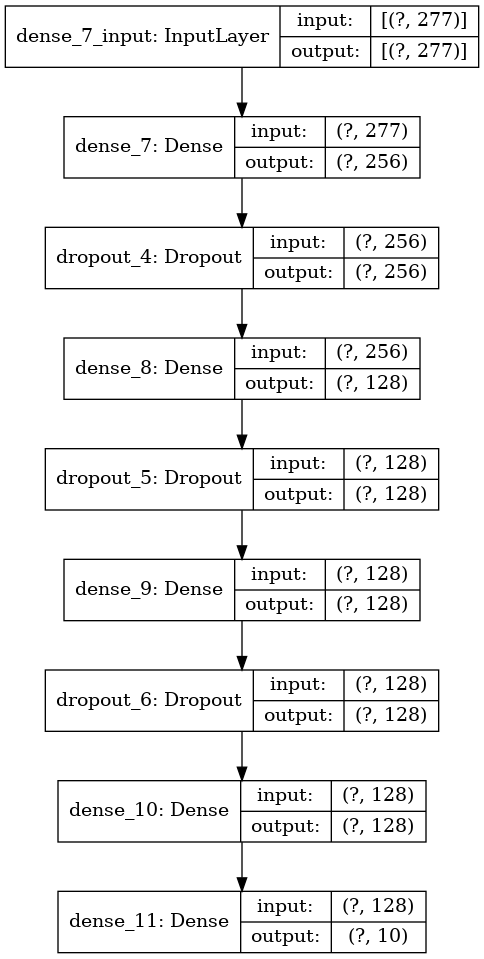

In [25]:
utils.plot_model(
    model, show_shapes=True,
)

In [26]:
history = model.fit(
    trainData,
    trainLabel,
    validation_data=(validData, validLabel),
    verbose=0,  # 不顯示過程
    epochs=200,
    batch_size=128,
)

In [27]:
model.evaluate(validData, validLabel)

4/4 [==============================] - 0s 925us/step - loss: 0.2180 - accuracy: 0.9600


[0.21803756058216095, 0.9599999785423279]

In [28]:
model.evaluate(pitchShiftTestData, pitchShiftTestLabel)

4/4 [==============================] - 0s 986us/step - loss: 0.1379 - accuracy: 0.9600


[0.1378871351480484, 0.9599999785423279]

In [29]:
model2 = cnn(trainData.reshape(1000, 277, 1).shape)

In [30]:
model2.compile(
    optimizer=optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-6, nesterov=True),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

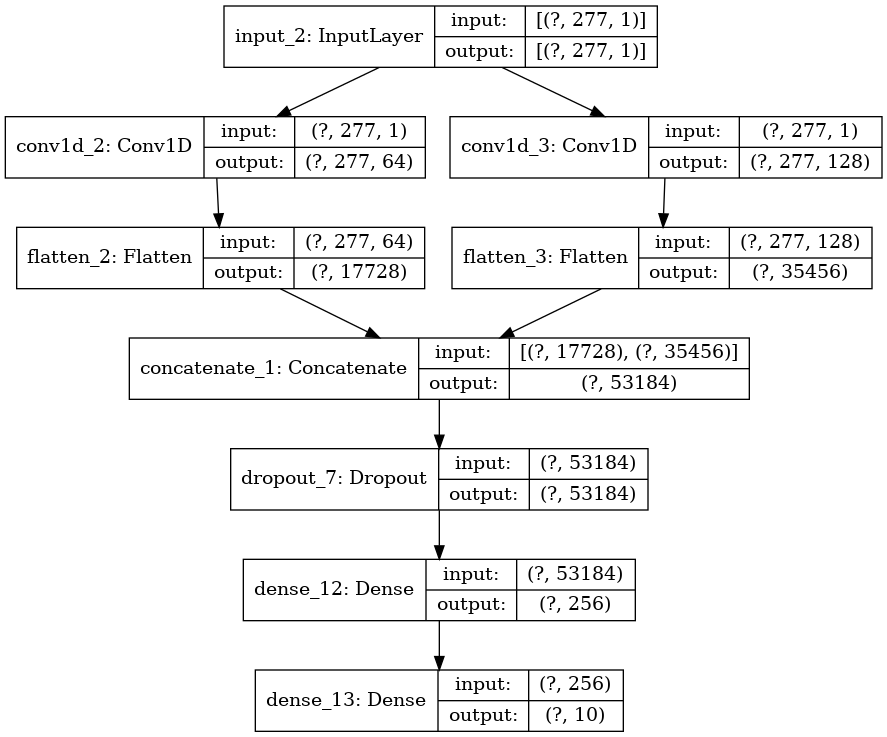

In [31]:
utils.plot_model(
    model2, show_shapes=True,
)

In [32]:
history2 = model2.fit(
    trainData.reshape(1000, 277, 1),
    trainLabel,
    validation_data=(validData.reshape(100, 277, 1), validLabel),
    verbose=0,  # 不顯示過程
    epochs=25,
    batch_size=128,
)

In [33]:
model2.evaluate(validData.reshape(100, 277, 1), validLabel)

4/4 [==============================] - 0s 2ms/step - loss: 0.1321 - accuracy: 0.9600


[0.13205033540725708, 0.9599999785423279]

In [34]:
model2.evaluate(pitchShiftTestData.reshape(100, 277, 1), pitchShiftTestLabel)

4/4 [==============================] - 0s 2ms/step - loss: 0.1007 - accuracy: 0.9600


[0.10066544264554977, 0.9599999785423279]